# 1.7 最初のアプリケーション：アイリスのクラス分類
【目標】

新しく見つけたアイリス(アヤメ科アヤメ属の花)の種類を予測するために、

種類がわかっているアイリスの測定値を用いて機械学習モデルを構築すること。

※0:setosa, 1:versicolor, 2:virgnicaの種類がある。

※花弁の長さと幅, ガクの長さと幅をcm単位で測定

- 目標の機械学習モデルは、**教師あり学習**となる。
- 複数の選択肢(アイリスの種類)の中から1つ選ぶクラス分類(classification)問題の一例となる。
- 出力は**クラス**(class)

## 1.7.1 データを読む
使用するデータセット：irisデータセット

※機械学習や統計で古くから用いられるデータセット

※scikit-learnのdatasetsモジュールに含まれており、load_irid関数で読み込み可能

In [22]:
from sklearn.datasets import load_iris

iris_dataset = load_iris()

print('Keys of iris_dataset:\n{}'.format(iris_dataset.keys()))

# キーDESCEの値は、データセットの簡単な説明(description)
# 説明の最初の部分だけを見る。
print(iris_dataset['DESCR'][:193]+'\n...')

Keys of iris_dataset:
dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, pre
...


In [23]:
# キーtarget_namesに対応する値は文字列の配列で、予測しようとしている花の種類が格納されている。
print('Target names:{}'.format(iris_dataset['target_names']))

Target names:['setosa' 'versicolor' 'virginica']


In [24]:
# キーfeature_namesに対応する値は文字列のリストで、それぞれの特徴量の説明が格納されている。
print('Feature names:\n{}'.format(iris_dataset['feature_names']))

Feature names:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [25]:
# データ本体は、targetとdataフィールドに格納されている。
# dataには、ガクの長さ, ガクの幅, 花弁の長さ, 花弁の幅がNumPy配列として格納されている。
print('Type of data : {}'.format(type(iris_dataset['data'])))
print('Shape of data : {}'.format(iris_dataset['data'].shape))

Type of data : <class 'numpy.ndarray'>
Shape of data : (150, 4)


# 1.7.2 成功度合いの測定：訓練データとテストデータ
構築したモデルを新たに計測したデータに適用する間に、そのモデルが実際に機能するか、予測を信じてい良いかを知っておく必要がある。

モデルを構築するのに使ったデータをモデルの評価に使うことはできない。
    - モデルが訓練データを覚えてしまい、常に正確にラベルを予測できるようになるため。
    - モデルがうまく**汎化**できていることの指標にはならない。 

**訓練データ, 訓練セット(training data, training set)**を機械学習モデルの構築に用いる。 

**テストデータ, テストセット(test data, test set)**または、**ホールドアウトセット(hold-out set)**をモデルの評価に用いる。

**train_test_split関数**：データセットを並び替えて、75%を訓練セット / 25%をテストセットに分割する。

※random_state は疑似乱数のシードを意味して、実行ごとに確実に同じ結果が得られるようになる。

※75%, 25%の比率はデフォルトであり、変えることはできる。

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    iris_dataset['data'], iris_dataset['target'], random_state=0
)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (112, 4)
y_train shape: (112,)
X_test shape: (38, 4)
y_test shape: (38,)


## 1.7.3 最初にすべきこと：データをよく観察する
機械学習モデルの構築の前に、**データを検査する**のが重要

- データ内の異常値やおかしな点が存在する。
    - アイリスの鼻の一部がcmではなくインチで計測されいるかもしれない。
- データを検査する最良の方法は、**可視化** (その1つが散布図)
    - 3つを超える特徴量の散布図では、ペアプロット(すべての組み合わせ可能な特徴量の組み合わせをプロットする)を行う。

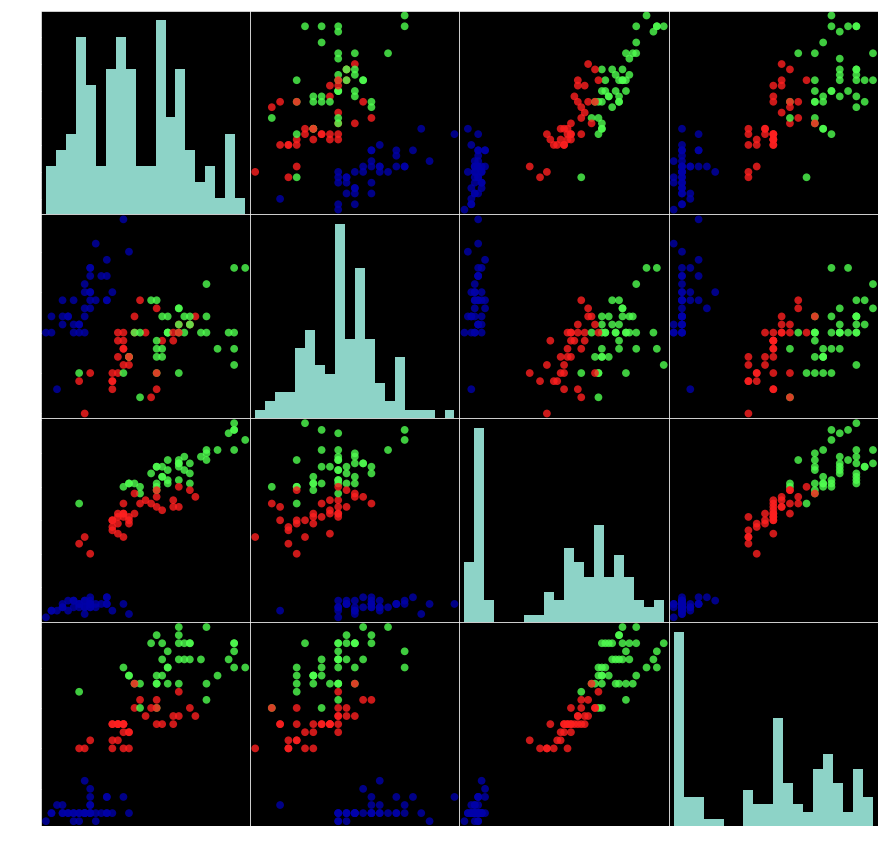

In [27]:
# X_trainのデータからDataFrameを作る。
# iris_dataset.feature_namesの文字列を使ってカラムに名前を付ける。
import pandas as pd
import mglearn
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
iris_dataframe = pd.DataFrame(X_train, columns=iris_dataset.feature_names)
# データフレームからscatter matrixを作成し、y_trainに従って色をつける。
grr = scatter_matrix(iris_dataframe, c=y_train, figsize=(15,15), marker='o', 
        hist_kwds={'bins':20}, s=60, alpha=.8, cmap=mglearn.cm3)

## 1.7.4 最初のモデル：k-最近傍法
k-最近傍法(k-Neares Neighbors)

新しいデータポイントに対して予測する際に、新しい点に最も近い点を訓練セットから探し、新しい点に最も近かった点のラベルを、新しいデータポイントに与える。

kは、新しい点に最も近い1点だけを用いるのではなく、訓練セット中の固定されたk個の近傍点(3,5とか)を用いることもできる。

詳細は、scikit-learnのAPIドキュメント[k-最近傍法](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)を参照


In [28]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
# 訓練セットからモデルを構築するのにはknnオブジェクトのfitメソッドを呼び出す。
knn.fit(X_train, y_train)
# 表示されるのは、デフォルトで設定されているパラメータ

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

## 1.7.5 予測を行う
knnで構築した機械学習モデルで予測を行う。

この際に、1つの花の測定結果を2次元のNumPy配列にする必要がある。

※scikit-learnが常に入力が2次元NumPy配列であることを前提としているからである。

In [30]:
import numpy as np
X_new = np.array([[5,2.9,1,0.2]])
prediction = knn.predict(X_new)
print('Prediction:{}'.format(prediction))
print('Predicted target name:{}'.format(iris_dataset['target_names'][prediction]))

Prediction:[0]
Predicted target name:['setosa']


## 1.7.6 モデルの評価
モデルがどのくらいうまく機能しているか、**精度(accuracy)**を求める。

※精度(accuracy)：正しく品種を予測できたアイリスの割合

In [32]:
y_pred = knn.predict(X_test)
print('Test set predictions :\n{}'.format(y_pred))
print('Test set score:{:2f}'.format(np.mean(y_pred==y_test)))
print('Test set score:{:2f}'.format(knn.score(X_test, y_test)))

Test set predictions :
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]
Test set score:0.973684
Test set score:0.973684


機械学習モデルは、テストセットに対する精度はおよそ0.97、

テストセットに含まれるアイリスの97%に対して正確な予測ができた。

以降の章では、性能をさらに向上させる方法やモデルをチューニングする際の注意について述べる。